# Outliers and Their Influence on the Final Model - tutorial

## Table of Contents:

1. Read point data and take 10% of it as a sample for the further analysis (dataset A),
2. Check if outliers are present in a data and create additional dataset without outliers (dataset B),
3. Create the Variogram Point Cloud model for the datasets A and B,
4. Remove outliers from the datasets A and B,
5. Create four Ordinary Kriging models and compare their performance.

## Level: Intermediate

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-10-13 | Refactored TheoreticalSemivariogram (name change of class attribute) and refactored `calc_semivariance_from_pt_cloud()` function to protect calculations from `NaN's`. | @ethmtrgt & @SimonMolinsky |
| 2021-08-22 | Initial release | @SimonMolinsky |

## Introduction

Outliers may affect our analysis and the final interpolation results. In this tutorial we learn about their influence on the final model and we compare interpolation error for different scenarios where data is treated in a different ways. 

We are able to remove too high or too low values at the preprocessing stage (check part 2 of the tutorial) or we can remove outliers directly from the variogram point cloud (part 4). Results from each type of preprocessing (and a raw dataset analysis) are different and we are going to compare them.

We use: 

- DEM data which is stored in a file `sample_data/point_data/poland_dem_gorzow_wielkopolski`.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyinterpolate.distance import calc_point_to_point_distance
from pyinterpolate.io_ops import read_point_data
from pyinterpolate.kriging import Krige
from pyinterpolate.semivariance import build_variogram_point_cloud, show_variogram_cloud, remove_outliers
from pyinterpolate.semivariance import calc_semivariance_from_pt_cloud
from pyinterpolate.semivariance import TheoreticalSemivariogram

## 1) Read point data and divide it into training and test set

In [2]:
# Read data from file

dem = read_point_data('../sample_data/point_data/poland_dem_gorzow_wielkopolski', data_type='txt')

In [3]:
# Divide data into training and test set

def create_train_test(data, training_fraction):
    idxs = np.arange(0, len(data))
    number_of_training_samples = int(len(data) * training_fraction)
    training_idxs = np.random.choice(idxs, size=number_of_training_samples, replace=False)
    test_idxs = [i for i in idxs if i not in training_idxs]
    training_set = data[training_idxs, :]
    test_set = data[test_idxs, :]
    
    return training_set, test_set

In [4]:
train, test = create_train_test(dem, 0.1)

In [5]:
train

array([[15.33317125, 52.75417495, 83.18280029],
       [15.19671758, 52.60017234, 40.88224411],
       [15.35611128, 52.59065068, 49.91086197],
       ...,
       [15.22677694, 52.78336092, 44.85400009],
       [15.29717912, 52.781291  , 69.5343399 ],
       [15.24971698, 52.73865049, 56.7199173 ]])

## 2) Check outliers: analyze distribution of the values

To find if our dataset contains outliers we are going to inspect all values in the `train` set. At the beginning we plot data distribution with the `violinplot`.

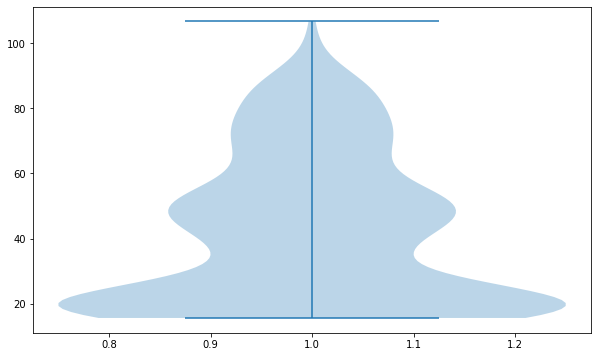

In [6]:
# Distribution plot

plt.figure(figsize=(10, 6))
plt.violinplot(train[:, -1])
plt.show()

> **NOTE:** Your plot may be different than presented in the tutorial. Why is that? Because we take a random sample of 10% of values and after each iteration the algorithm takes different points for the analysis.

**Clarification:**

Investigation of the plot tells us that our data is:

- grouped around the lowest values, and most of the values are below 50 meters,
- has (probably) three different distributions mixed together, it can be a sign that Digital Elevation Model covers three different types of the elevation. One is grouped around 20 meters, next around 50 meters and the faintest is visible around 70 meters.

**Violinplot** is good for the distribution analysis. Especially if we are looking for the complex patterns in the dataset. But reading outliers from it may be challenging and we should change a plot type to understand if outliers exist in a dataset. The good choice is the `boxplot`:

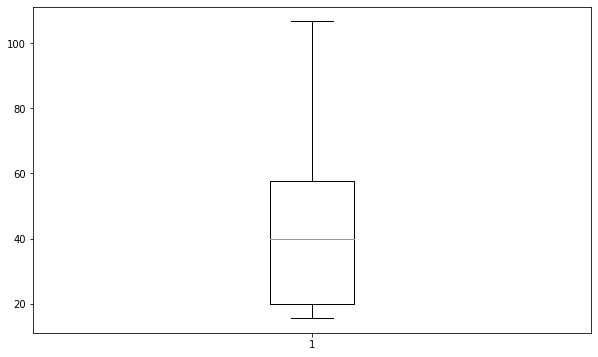

In [7]:
# Boxplot

plt.figure(figsize=(10, 6))
plt.boxplot(train[:, -1])
plt.show()

**Boxplot** is a special and very useful tool for the data visualization and analysis. Let's analyze this plot from the bottom up to the top.

> **NOTE:** Boxplot represents values sorted in the ascending order and their statistical properties: quartiles, median and outliers.

- The bottom whisker (horizontal line) represents the lower range of values in our dataset,
- The box lower line is the first quartile of a data or, in other words, 25% of values of our dataset are below this point. We name it Q1.
- The middle line is a median of our dataset. We name it Q2 or median.
- The upper line is the third quartile of a data or, in other words, 75% of values are below this point,
- The top whisker represents the upper range of values in our dataset. We name it Q3.
- Individual points (if they are exist then we see them as a points below the bottom whisker or above the top whisker) are considered as outliers. They could be outliers in the upper range as well as lower range of our data. Long distance between Q1 and the bottom whisker and/or between Q3 and the top whisker is an indicator of potential outliers. Package **matplotlib** calculates potential outliers based on the absolute distance from the Q1 or Q3 to the whiskers. Points below or above this distance are treated as outliers. The outlier distance is calculated as the $weight * (Q3 - Q1)$ where we can set `weight` but other parameters are read directly from the data.

We use this knowledge to remove outliers from the dataset with the assumption that _outliers are rather anomalies than unbiased readings_. We will perform the outlier removal from the data with a more *aggresive* assumption than it is done in **matplotlib** and we set weight to the `1.0`.

In [8]:
# Create training set without outliers

q1 = np.quantile(train[:, -1], 0.25)
q3 = np.quantile(train[:, -1], 0.75)

top_limit = q3 + (q3 - q1)

train_without_outliers = train[train[:, -1] < top_limit]

In [9]:
print('Length of the full training set is {} records'.format(len(train)))
print('Length of the pre-processed training set is {} records'.format(len(train_without_outliers)))

Length of the full training set is 689 records
Length of the pre-processed training set is 685 records


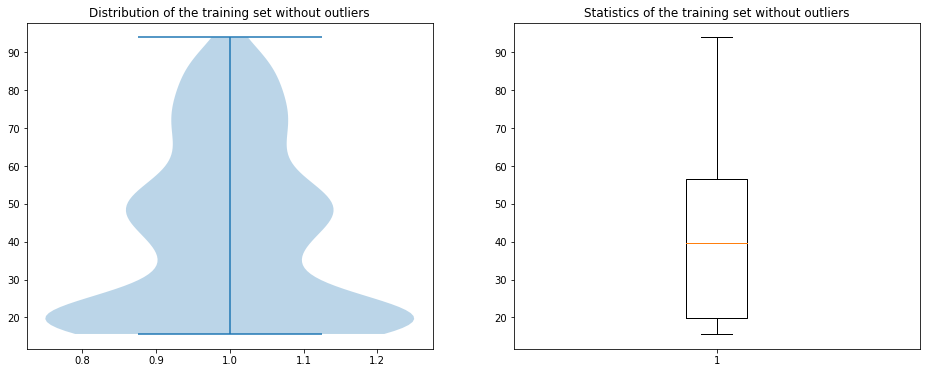

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].violinplot(train_without_outliers[:, -1])
ax[0].set_title('Distribution of the training set without outliers')
ax[1].boxplot(train_without_outliers[:, -1])
ax[1].set_title('Statistics of the training set without outliers')
plt.show()

**Clarification**: with our data processing we have cut some records from the baseline training dataset. Distribution plot (`violinplot`) has shorter tail and ends more abruptly; and a `boxplot` of the new data doesn't have any outliers. The one important thing to notice is that the observations are still skewed but this is not a problem for this concrete tutorial.

> **NOTE**: if you are eager to know how to deal with the skewed datasets we recommend article [**Transforming Skewed Data**](https://anatomisebiostats.com/biostatistics-blog/transforming-skewed-data/).

## 3) Create the Variogram Point Cloud model for datasets A and B

Now we are making one step further and we will transform both datasets with- and without- outliers and calculate variogram point clouds from these. Then we compare both variogram point clouds.

In [11]:
def get_variogram_point_cloud(dataset, max_range, number_of_lags=16):
    distances = calc_point_to_point_distance(dem[:, :-1])
    step_size = max_range / number_of_lags
    cloud = build_variogram_point_cloud(dataset, step_size, max_range)
    return cloud

In [12]:
full_distance = np.max(calc_point_to_point_distance(train[:, :-1]))

cloud_full = get_variogram_point_cloud(train, full_distance)
cloud_processed = get_variogram_point_cloud(train_without_outliers, full_distance)

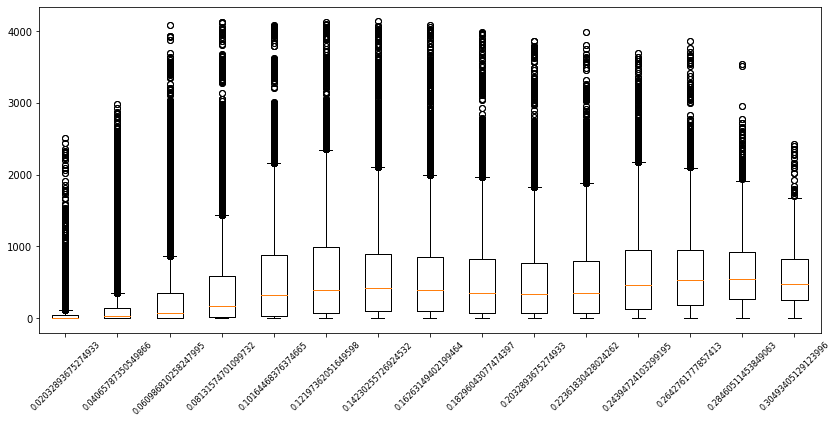

In [13]:
# Show variogram cloud: initial training dataset

show_variogram_cloud(cloud_full, plot_type='boxplot')

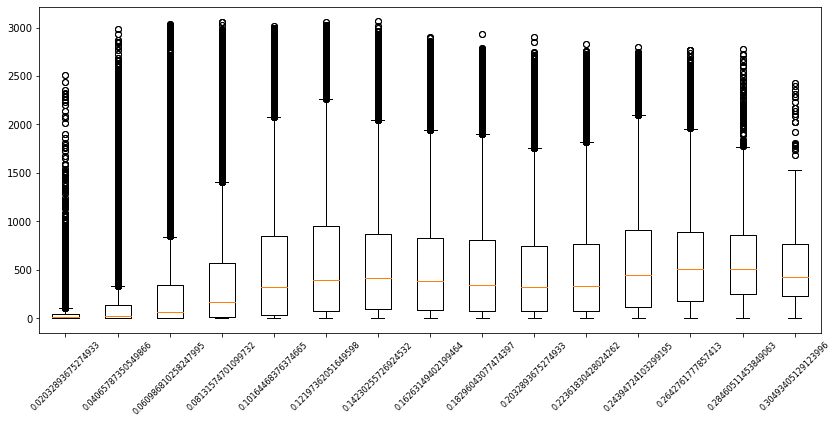

In [14]:
# Show variogram cloud: pre-processed training dataset

show_variogram_cloud(cloud_processed, plot_type='boxplot')

**Clarification:** a quick look into the results shows that each lag is full of outliers in the top part of the semivariances values. Processed dataset has lowest absolute semivariance than the raw readings. Both variograms have a similar shape. Dispersion of semivariances seems to be very high in both cases. It is especially alarming when we consider the shortest distances where abrupt changes in the elevation are not so likely.

In the next cell we will check a standard deviation of the lag variances.

In [15]:
for k, v in cloud_full.items():
    print('Lag {:.2f}'.format(k))
    
    v_raw = int(np.std(v))
    v_pro = int(np.std(cloud_processed[k]))
    v_smape = 100 * (np.abs(v_raw - v_pro) / (0.5 * (v_raw + v_pro)))
    
    print('Standard Deviation raw dataset:', v_raw)
    print('Standard Deviation processed dataset:', v_pro)
    print('Symmetric Mean Absolute Percentage Error of Variances: {:.2f}'.format(v_smape))
    print('')

Lag 0.02
Standard Deviation raw dataset: 222
Standard Deviation processed dataset: 223
Symmetric Mean Absolute Percentage Error of Variances: 0.45

Lag 0.04
Standard Deviation raw dataset: 444
Standard Deviation processed dataset: 446
Symmetric Mean Absolute Percentage Error of Variances: 0.45

Lag 0.06
Standard Deviation raw dataset: 601
Standard Deviation processed dataset: 580
Symmetric Mean Absolute Percentage Error of Variances: 3.56

Lag 0.08
Standard Deviation raw dataset: 681
Standard Deviation processed dataset: 653
Symmetric Mean Absolute Percentage Error of Variances: 4.20

Lag 0.10
Standard Deviation raw dataset: 722
Standard Deviation processed dataset: 693
Symmetric Mean Absolute Percentage Error of Variances: 4.10

Lag 0.12
Standard Deviation raw dataset: 723
Standard Deviation processed dataset: 683
Symmetric Mean Absolute Percentage Error of Variances: 5.69

Lag 0.14
Standard Deviation raw dataset: 680
Standard Deviation processed dataset: 642
Symmetric Mean Absolute P

**Clarification:** The differences (sMAPE) per lag vary a lot. We can see that the preprocessing of raw values introduces the information lost. It is especially painful for the closest neighbors. It doesn't mean that the preprocessing of raw observations is not recommended but it is a good idea to include the **spatial component** in the outliers detection process.

Not everything is wrong. Data cleaning has lowered the semivariances dispersion for the middle lags (where we have the largest number of point pairs for the analysis).

At this point we are not able to judge which dataset is better for the modeling. Instead we are going to remove outliers from the both **variograms** (instead of the **raw data**).

## 4) Remove outliers from the variograms

In this step we are going to use **pyinterpolate's** function `remove_outliers()` to build additional two variogram point clouds from the raw and processed datasets. We delete the top part outliers of the **semivariance values** rather than the raw readings.

In [16]:
raw_without_outliers = remove_outliers(cloud_full, exclude_part='top', weight=1.25)
prep_without_outliers = remove_outliers(cloud_processed, exclude_part='top', weight=1.25)

In [17]:
data_raw = [x for x in cloud_full.values()]
data_raw_not_out = [x for x in raw_without_outliers.values()]
data_prep = [x for x in cloud_processed.values()]
data_prep_not_out = [x for x in prep_without_outliers.values()]

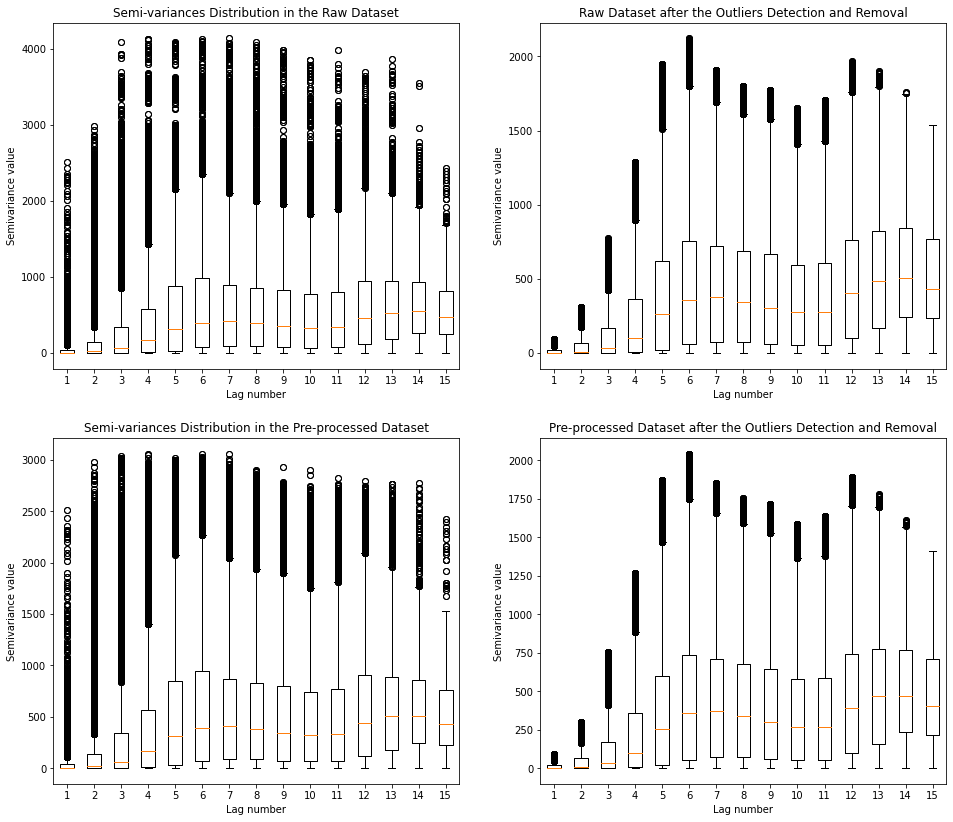

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

ax[0, 0].boxplot(data_raw)
ax[0, 0].set_title('Semi-variances Distribution in the Raw Dataset')
ax[0, 0].set_xlabel('Lag number')
ax[0, 0].set_ylabel('Semivariance value')

ax[0, 1].boxplot(data_raw_not_out)
ax[0, 1].set_title('Raw Dataset after the Outliers Detection and Removal')
ax[0, 1].set_xlabel('Lag number')
ax[0, 1].set_ylabel('Semivariance value')

ax[1, 0].boxplot(data_prep)
ax[1, 0].set_title('Semi-variances Distribution in the Pre-processed Dataset')
ax[1, 0].set_xlabel('Lag number')
ax[1, 0].set_ylabel('Semivariance value')

ax[1, 1].boxplot(data_prep_not_out)
ax[1, 1].set_title('Pre-processed Dataset after the Outliers Detection and Removal')
ax[1, 1].set_xlabel('Lag number')
ax[1, 1].set_ylabel('Semivariance value')

plt.show()

**Clarification:** Comparison of multiple variogram clouds could be hard. We see that the largest semivariances are present in the raw data. A heavily processed data has the lowest number of outliers. The medians in each dataset are distributed over a similar pattern. How is it similar? We can check it if we transform the variogram point cloud into the experimental semivariogram. Pyinterpolate has function for it: `calc_semivariance_from_pt_cloud()`. We use it and compare four plots of semivariances to gain more insight into the transformations.

In [19]:
raw_semivar = calc_semivariance_from_pt_cloud(cloud_full)
raw_semivar_not_out = calc_semivariance_from_pt_cloud(raw_without_outliers)
prep_semivar = calc_semivariance_from_pt_cloud(cloud_processed)
prep_semivar_not_out = calc_semivariance_from_pt_cloud(prep_without_outliers)

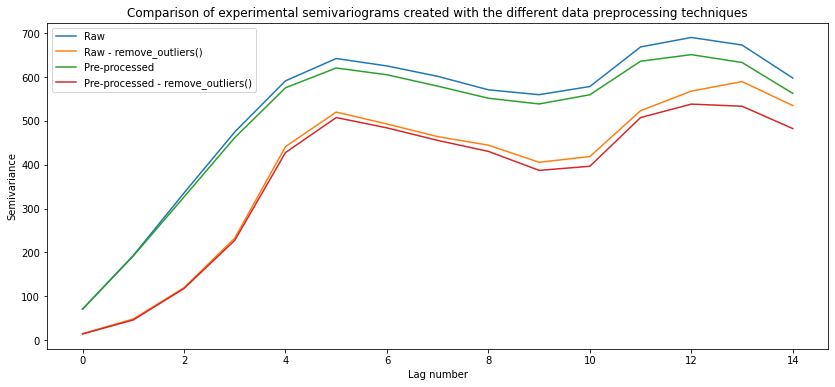

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(raw_semivar[:, 1])
plt.plot(raw_semivar_not_out[:, 1])
plt.plot(prep_semivar[:, 1])
plt.plot(prep_semivar_not_out[:, 1])
plt.title('Comparison of experimental semivariograms created with the different data preprocessing techniques')
plt.ylabel('Semivariance')
plt.xlabel('Lag number')
plt.legend(['Raw', 'Raw - remove_outliers()', 'Pre-processed', 'Pre-processed - remove_outliers()'])
plt.show()

**Clarification:** An understanding of those plots is not an easy task. Let's divide reasoning into multiple points:

- Raw dataset and preprocessed raw dataset show a similar pattern, the differences are more pronounced for the distant lags than for the closest point pairs,
- Datasets with the cleaned variograms are different from the raw data. The absolute semivariance values per lag are smaller and the semivariogram pattern is slightly different. What is interesting is that the possible two distributions within the dataset are more visible in the case of cleaned variograms (one distribution with a peak around 6th lag and other with a peak around 13th lag).
- The differences between semivariograms are mostly visible at larger distances. For the closest point pairs differences are smaller.

Semivariograms visual inspection does not infor us of the modeling performance but we can assume that models will be slightly different. Let's test this assumption!

## 5) Create Four Ordinary Kriging models based on the four Variogram Point Clouds and compare their performance

In [21]:
number_of_ranges = 32

# Fit different semivariogram models into prepared datasets and variograms

# Raw
raw_theo = TheoreticalSemivariogram(points_array=train,
                                    empirical_semivariance=raw_semivar)
_ = raw_theo.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

# Raw with cleaned variogram
raw_theo_no_out = TheoreticalSemivariogram(points_array=train,
                                           empirical_semivariance=raw_semivar_not_out)
_ = raw_theo_no_out.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

# Preprocessed
prep_theo = TheoreticalSemivariogram(points_array=train_without_outliers,
                                     empirical_semivariance=prep_semivar)
_ = prep_theo.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

# Preprocessed with cleaned variogram
prep_theo_no_out = TheoreticalSemivariogram(points_array=train_without_outliers,
                                            empirical_semivariance=prep_semivar_not_out)
_ = prep_theo_no_out.find_optimal_model(weighted=False, number_of_ranges=number_of_ranges)

In [22]:
# Set Kriging models

# Raw
raw_model = Krige(semivariogram_model=raw_theo, known_points=train)

# Raw & cleaned
c_raw_model = Krige(semivariogram_model=raw_theo_no_out, known_points=train)

# Preprocessed
prep_model = Krige(semivariogram_model=prep_theo, known_points=train_without_outliers)

# Preprocessed & cleaned
c_prep_model = Krige(semivariogram_model=prep_theo_no_out, known_points=train_without_outliers)

In [23]:
# Build test function

def test_kriging_model(model, test_set, max_nn=32):
    """
    Function tests performance of a given kriging model.
    
    INPUT:
    
    :param model: (Krige) Kriging model,
    :param test_set: (array),
    :param max_nn: (int) default=256, maximum number of neighbors.
    
    OUTPUT:
    
    :returns: (list) root mean squared errors of prediction
    """
    rmses = []
    for pt in test_set:
        coordinates = pt[:-1]
        value = pt[-1]
        
        predicted = model.ordinary_kriging(coordinates, max_no_neighbors=max_nn)[0]
        
        error = np.sqrt((value - predicted)**2)
        rmses.append(error)
    return rmses

In [24]:
r_test = test_kriging_model(raw_model, test)

In [25]:
cr_test = test_kriging_model(c_raw_model, test)

In [26]:
p_test = test_kriging_model(prep_model, test)

In [27]:
cp_test = test_kriging_model(c_prep_model, test)

In [28]:
df = pd.DataFrame(data=np.array([r_test, cr_test, p_test, cp_test]).transpose(),
                  columns=['Raw', 'Raw-cleaned', 'Preprocessed', 'Preprocessed-cleaned'])

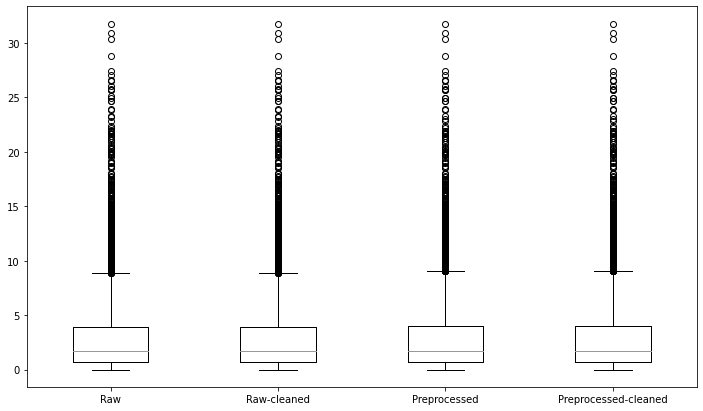

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.boxplot(df)
ax.set_xticklabels(['Raw',
                    'Raw-cleaned',
                    'Preprocessed',
                    'Preprocessed-cleaned'])
plt.show()

It is very hard to distinguish any differences in the figure but we can use `.describe()` method of **pandas** to get the columns statistic:

In [30]:
df.describe()

,Raw,Raw-cleaned,Preprocessed,Preprocessed-cleaned
count,6206.000000,6206.000000,6206.000000,6206.000000
mean,3.010941,3.010941,3.039950,3.039950
std,3.669928,3.669928,3.696327,3.696327
min,0.000068,0.000068,0.000068,0.000068
25%,0.669112,0.669112,0.667826,0.667826
50%,1.659948,1.659948,1.668606,1.668606
75%,3.940064,3.940064,4.008921,4.008921
max,31.770417,31.770417,31.770417,31.770417


**Clarification:** In this particular case the final statistics goes hand in hand with the initial assumptions that:

**a)** Raw dataset has lowest error of prediction. The rationale behind it is that if we throw away the observations at the preprocessing step we risk an information lost. It could damage our model.

**b)** Raw dataset with the **cleaned variogram** is the best one. We have removed the point pairs with the largest error. In reality we got rid off the potentially wrong measurements where at one point elevation is small and it's neighbour is very high.

> **NOTE:** Example in this tutorial is related to the Digital Elevation Model which was preprocessed by the data provider (*Copernicus Land Monitoring Services*). You shouldn't get impression that the raw data preprocessing and filtering is not required for the analysis. There are cases where the sensor may produce unreliable and biased results, as example a saturated pixel from the satellite camera. It is better to remove it with the specific noise-filtering algorithm before the variogram point cloud development.

---